# Emotions in context using the Emotic dataset

Notebook and code adapted from https://github.com/Tandon-A/emotic

# README

Make sure the following dependencies are installed. We recommened using a new conda environment.

- python=3.8
- pytorch <= 1.8.1
- scikit-learn
- numpy
- pandas
- matplotlib

## Links to EMOTIC dataset

This project uses the <a href="http://sunai.uoc.edu/emotic/download.html">EMOTIC dataset</a> and follows the methodology as introduced in the paper <a href="https://arxiv.org/pdf/2003.13401.pdf">'Context based emotion recognition using EMOTIC dataset'</a>.

To make it easier for you we have hosted the EMOTIC dataset as well, if you intend to make use of it.

**Link to data**: https://tud365.sharepoint.com/:f:/s/ConversationalAgents2021/EoSyoFarxCJFoZrfkgft3iQBnpRRPZNavJ6La5ZfRhrFXw?e=61LcKf

If you do not wish to train the model from scratch, section 12 will show you how you can use pretrained versions of the model along with a few examples

In [ ]:
# please change the cuda version to whatever is supported by your GPU, in case you do not have have an nvidia GPU
# run the commented command instead
!conda install pytorch=1.8.1 torchvision torchaudio cudatoolkit=11.1 -c pytorch-lts -c nvidia

# !conda install pytorch torchvision torchaudio cpuonly -c pytorch-lts

# Dataset pre-processing and conversion to .npy

- Download the EMOTIC dataset and unzip it
- Download the Annotations.zip and unzip it as well
- Make sure you follow the below directory structure as this is important for later steps

<pre>
emotic/data
├── Annotations
│   ├── Annotations.mat
│   ├── demo.m
│   ├── demo_single.m
│   ├── displayAnnotation.m
│   ├── displayAnnotation_multiple.m
│   ├── README_demo.txt
│   └── README_EMOTIC_annotationsStructure.pdf
├── Annotations.zip
├── emotic
│   ├── ade20k
│   ├── emodb_small
│   ├── emotic_pre
│   ├── framesdb
│   └── mscoco
└── emotic.zip
</pre>

### Installing OpenCV 

There are two ways to install OpenCV:
1. If you do not have a GPU you can install it via conda
    - conda install -c conda-forge  opencv
2. In case you want a CUDA enabled version the path is a bit *treacherous*

Now we are ready to convert this into the npy format. This has the benefit of being faster to load and consume less memory

In [ ]:
# This will take a long time!!
!python emotic/mat2py.py --data_dir emotic/data --generate_npy

<h1>Project context</h1>

Humans use their facial features or expressions to convey how they feel, such as a person may smile when happy and scowl when angry. Historically, computer vision research has focussed on analyzing and learning these facial features to recognize emotions. 
However, these facial features are not universal and vary extensively across cultures and situations. 

<figure>
<img src="https://raw.githubusercontent.com/Tandon-A/emotic/master/assets/face.jpg"> <img src="https://raw.githubusercontent.com/Tandon-A/emotic/master/assets/full_scene.jpg" width="400">
  <figcaption>Fig 1: a) (Facial feature) The person looks angry or in pain b) (Whole scene) The person looks elated.</figcaption>
</figure>


A scene context, as shown in the figure above, can provide additional information about the situations. This project explores the use of context in recognizing emotions in images. 

# Prepare places pretrained model

In [3]:
# Get Resnet18 model trained on places dataset. 
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar -O ./places/resnet18_places365.pth.tar

--2021-07-22 12:44:16--  http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.30.195.26
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.30.195.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45506139 (43M) [application/x-tar]
Saving to: ‘./places/resnet18_places365.pth.tar’

./places/resnet18_p 100%[===================>]  43,40M  24,6MB/s    in 1,8s    

2021-07-22 12:44:19 (24,6 MB/s) - ‘./places/resnet18_places365.pth.tar’ saved [45506139/45506139]



In [2]:
# Converting model weights to python3.6 format
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os

model_path = './places'
archs = ['resnet18']
for arch in archs:
    model_file = os.path.join(model_path, '%s_places365.pth.tar' % arch)
    save_file = os.path.join(model_path, '%s_places365_py36.pth.tar' % arch)

    from functools import partial
    import pickle
    pickle.load = partial(pickle.load, encoding="latin1")
    pickle.Unpickler = partial(pickle.Unpickler, encoding="latin1")
    model = torch.load(model_file,
                       map_location=lambda storage, loc: storage,
                       pickle_module=pickle)
    torch.save(model, save_file)
    print('converting %s -> %s' % (model_file, save_file))

converting ./places/resnet18_places365.pth.tar -> ./places/resnet18_places365_py36.pth.tar


In [3]:
# Saving the model weights to use ahead in the notebook
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from PIL import Image
from torchvision import transforms as trn
from torch.nn import functional as F
import os

# the architecture to use
arch = 'resnet18'
model_weight = os.path.join(model_path, 'resnet18_places365_py36.pth.tar')

# create the network architecture
model = models.__dict__[arch](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model, os.path.join(model_path, 'res_context' + '.pth'))

# General imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import scipy.io
from sklearn.metrics import average_precision_score, precision_recall_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

from tqdm.auto import tqdm, trange

# Emotic classes

## Emotic Model 

This model has been adapted from the paper: <a href="https://arxiv.org/pdf/2003.13401.pdf">'Context based emotion recognition using EMOTIC dataset'</a>

**It is recommened that you read the paper to understand the rationale of the model**

![](assets/nw_arch.png)
Image borrowed from linked paper

In [2]:
class Emotic(nn.Module):
    ''' Emotic Model'''
    def __init__(self, num_context_features, num_body_features):
        super(Emotic, self).__init__()
        self.num_context_features = num_context_features
        self.num_body_features = num_body_features
        self.fc1 = nn.Linear((self.num_context_features + num_body_features),
                             256)
        self.bn1 = nn.BatchNorm1d(256)
        self.d1 = nn.Dropout(p=0.5)
        self.fc_cat = nn.Linear(256, 26)
        self.fc_cont = nn.Linear(256, 3)
        self.relu = nn.ReLU()

    def forward(self, x_context, x_body):
        context_features = x_context.view(-1, self.num_context_features)
        body_features = x_body.view(-1, self.num_body_features)
        fuse_features = torch.cat((context_features, body_features), 1)
        fuse_out = self.fc1(fuse_features)
        fuse_out = self.bn1(fuse_out)
        fuse_out = self.relu(fuse_out)
        fuse_out = self.d1(fuse_out)
        cat_out = self.fc_cat(fuse_out)
        cont_out = self.fc_cont(fuse_out)
        return cat_out, cont_out

## Emotic Dataset

In [4]:
class Emotic_PreDataset(Dataset):
    ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
    def __init__(self, x_context, x_body, y_cat, y_cont, transform,
                 context_norm, body_norm):
        super(Emotic_PreDataset, self).__init__()
        self.x_context = x_context
        self.x_body = x_body
        self.y_cat = y_cat
        self.y_cont = y_cont
        self.transform = transform
        self.context_norm = transforms.Normalize(
            context_norm[0], context_norm[1]
        )  # Normalizing the context image with context mean and context std
        self.body_norm = transforms.Normalize(
            body_norm[0], body_norm[1]
        )  # Normalizing the body image with body mean and body std

    def __len__(self):
        return len(self.y_cat)

    def __getitem__(self, index):
        image_context = self.x_context[index]
        image_body = self.x_body[index]
        cat_label = self.y_cat[index]
        cont_label = self.y_cont[index]
        return self.context_norm(
            self.transform(image_context)), self.body_norm(
                self.transform(image_body)), torch.tensor(
                    cat_label, dtype=torch.float32), torch.tensor(
                        cont_label, dtype=torch.float32) / 10.0

## Emotic Losses

These are custom loss functions. We need these are there is a direct relation between the continuous V-A-D values and the emotion labels therefore the loss needs to account for it as well

In [5]:
class DiscreteLoss(nn.Module):
    ''' Class to measure loss between categorical emotion predictions and labels.'''
    def __init__(self, weight_type='mean', device=torch.device('cpu')):
        super(DiscreteLoss, self).__init__()
        self.weight_type = weight_type
        self.device = device
        if self.weight_type == 'mean':
            self.weights = torch.ones((1, 26)) / 26.0
            self.weights = self.weights.to(self.device)
        elif self.weight_type == 'static':
            self.weights = torch.FloatTensor([
                0.1435, 0.1870, 0.1692, 0.1165, 0.1949, 0.1204, 0.1728, 0.1372,
                0.1620, 0.1540, 0.1987, 0.1057, 0.1482, 0.1192, 0.1590, 0.1929,
                0.1158, 0.1907, 0.1345, 0.1307, 0.1665, 0.1698, 0.1797, 0.1657,
                0.1520, 0.1537
            ]).unsqueeze(0)
            self.weights = self.weights.to(self.device)

    def forward(self, pred, target):
        if self.weight_type == 'dynamic':
            self.weights = self.prepare_dynamic_weights(target)
            self.weights = self.weights.to(self.device)
        loss = (((pred - target)**2) * self.weights)
        return loss.sum()

    def prepare_dynamic_weights(self, target):
        target_stats = torch.sum(target, dim=0).float().unsqueeze(dim=0).cpu()
        weights = torch.zeros((1, 26))
        weights[target_stats != 0] = 1.0 / torch.log(
            target_stats[target_stats != 0].data + 1.2)
        weights[target_stats == 0] = 0.0001
        return weights


class ContinuousLoss_L2(nn.Module):
    ''' Class to measure loss between continuous emotion dimension predictions and labels. Using l2 loss as base. '''
    def __init__(self, margin=1):
        super(ContinuousLoss_L2, self).__init__()
        self.margin = margin

    def forward(self, pred, target):
        labs = torch.abs(pred - target)
        loss = labs**2
        loss[(labs < self.margin)] = 0.0
        return loss.sum()


class ContinuousLoss_SL1(nn.Module):
    ''' Class to measure loss between continuous emotion dimension predictions and labels. Using smooth l1 loss as base. '''
    def __init__(self, margin=1):
        super(ContinuousLoss_SL1, self).__init__()
        self.margin = margin

    def forward(self, pred, target):
        labs = torch.abs(pred - target)
        loss = 0.5 * (labs**2)
        loss[(labs > self.margin)] = labs[(labs > self.margin)] - 0.5
        return loss.sum()

# Load preprocessed data

The cell below loads the pre-processed datasets. The preprocessing was done above when running the `mat2py.py` file

In [6]:
# Change data_src variable as per your drive
data_src = 'emotic/data/emotic_pre/'

# Load training preprocessed data
train_context = np.load(os.path.join(data_src, 'train_context_arr.npy'))
train_body = np.load(os.path.join(data_src, 'train_body_arr.npy'))
train_cat = np.load(os.path.join(data_src, 'train_cat_arr.npy'))
train_cont = np.load(os.path.join(data_src, 'train_cont_arr.npy'))

# Load validation preprocessed data
val_context = np.load(os.path.join(data_src, 'val_context_arr.npy'))
val_body = np.load(os.path.join(data_src, 'val_body_arr.npy'))
val_cat = np.load(os.path.join(data_src, 'val_cat_arr.npy'))
val_cont = np.load(os.path.join(data_src, 'val_cont_arr.npy'))

# Load testing preprocessed data
test_context = np.load(os.path.join(data_src, 'test_context_arr.npy'))
test_body = np.load(os.path.join(data_src, 'test_body_arr.npy'))
test_cat = np.load(os.path.join(data_src, 'test_cat_arr.npy'))
test_cont = np.load(os.path.join(data_src, 'test_cont_arr.npy'))

# Categorical emotion classes
cat = [
    'Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion',
    'Confidence', 'Disapproval', 'Disconnection', 'Disquietment',
    'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement',
    'Fatigue', 'Fear', 'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness',
    'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning'
]

cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(cat):
    cat2ind[emotion] = idx
    ind2cat[idx] = emotion

print('train ', 'context ', train_context.shape, 'body', train_body.shape,
      'cat ', train_cat.shape, 'cont', train_cont.shape)
print('val ', 'context ', val_context.shape, 'body', val_body.shape, 'cat ',
      val_cat.shape, 'cont', val_cont.shape)
print('test ', 'context ', test_context.shape, 'body', test_body.shape, 'cat ',
      test_cat.shape, 'cont', test_cont.shape)

train  context  (23266, 224, 224, 3) body (23266, 128, 128, 3) cat  (23266, 26) cont (23266, 3)
val  context  (3315, 224, 224, 3) body (3315, 128, 128, 3) cat  (3315, 26) cont (3315, 3)
test  context  (7203, 224, 224, 3) body (7203, 128, 128, 3) cat  (7203, 26) cont (7203, 3)


In [7]:
# setting the batch size for training, increase if needed
batch_size = 16

# setting the mean and standard deviation for all channels(3) of the images 
# this is used for normalising the dataset
context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]
body_mean = [0.43832874, 0.3964344, 0.3706214]
body_std = [0.24784276, 0.23621225, 0.2323653]
context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]

# dataset transforms and augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.ToTensor()
])
test_transform = transforms.Compose(
    [transforms.ToPILImage(), transforms.ToTensor()])

train_dataset = Emotic_PreDataset(train_context, train_body, train_cat,
                                  train_cont, train_transform, context_norm,
                                  body_norm)
val_dataset = Emotic_PreDataset(val_context, val_body, val_cat, val_cont,
                                test_transform, context_norm, body_norm)
test_dataset = Emotic_PreDataset(test_context, test_body, test_cat, test_cont,
                                 test_transform, context_norm, body_norm)

train_loader = DataLoader(train_dataset,
                          batch_size,
                          shuffle=True,
                          drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print('train loader ', len(train_loader), 'val loader ', len(val_loader),
      'test', len(test_loader))


train loader  1454 val loader  208 test 451


# Prepare emotic model

In [8]:
model_path_places = './places'
# NOTE:
# since we need two models as shown in the diagram above
# we make use of a ResNet-18 trained on the places dataset for the "context" network path
# abd a standard torch pretrained ResNet-18 for the "body" path
model_context = torch.load(os.path.join(model_path_places, 'res_context.pth'))
model_body = models.resnet18(pretrained=True)

emotic_model = Emotic(
    list(model_context.children())[-1].in_features,
    list(model_body.children())[-1].in_features)
model_context = nn.Sequential(*(list(model_context.children())[:-1]))
model_body = nn.Sequential(*(list(model_body.children())[:-1]))

# print (summary(model_context, (3,224,224), device="cpu"))
# print (summary(model_body, (3,128,128), device="cpu"))

## Prepare optimizer

In [9]:
for param in emotic_model.parameters():
    param.requires_grad = True
for param in model_context.parameters():
    param.requires_grad = False
for param in model_body.parameters():
    param.requires_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam(
    (list(emotic_model.parameters()) + list(model_context.parameters()) +
     list(model_body.parameters())),
    lr=0.001,
    weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_SL1 = ContinuousLoss_SL1()

# Train model

In [10]:
# this function contains the engineering code for the trainer
# contains logic to load a batch, forward pass, backward pass and validation step
def train_emotic(epochs,
                 model_path,
                 opt,
                 scheduler,
                 models,
                 disc_loss,
                 cont_loss,
                 cat_loss_param=0.5,
                 cont_loss_param=0.5):
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    train_loss = list()
    val_loss = list()

    model_context, model_body, emotic_model = models
    emotic_model.to(device)
    model_context.to(device)
    model_body.to(device)

    for e in trange(epochs):
        running_loss = 0.0

        emotic_model.train()
        model_context.train()
        model_body.train()

        for images_context, images_body, labels_cat, labels_cont in tqdm(
                train_loader, leave=False):
            images_context = images_context.to(device)
            images_body = images_body.to(device)
            labels_cat = labels_cat.to(device)
            labels_cont = labels_cont.to(device)

            opt.zero_grad()

            pred_context = model_context(images_context)
            pred_body = model_body(images_body)

            pred_cat, pred_cont = emotic_model(pred_context, pred_body)
            cat_loss_batch = disc_loss(pred_cat, labels_cat)
            cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
            loss = (cat_loss_param * cat_loss_batch) + (cont_loss_param *
                                                        cont_loss_batch)
            running_loss += loss.item()
            loss.backward()
            opt.step()

        if e % 1 == 0:
            print('epoch = %d training loss = %.4f' % (e, running_loss))
        train_loss.append(running_loss)

        running_loss = 0.0
        emotic_model.eval()
        model_context.eval()
        model_body.eval()

        with torch.no_grad():
            for images_context, images_body, labels_cat, labels_cont in tqdm(
                    val_loader, leave=False):
                images_context = images_context.to(device)
                images_body = images_body.to(device)
                labels_cat = labels_cat.to(device)
                labels_cont = labels_cont.to(device)

                pred_context = model_context(images_context)
                pred_body = model_body(images_body)

                pred_cat, pred_cont = emotic_model(pred_context, pred_body)
                cat_loss_batch = disc_loss(pred_cat, labels_cat)
                cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
                loss = (cat_loss_param * cat_loss_batch) + (cont_loss_param *
                                                            cont_loss_batch)
                running_loss += loss.item()

            if e % 1 == 0:
                print('epoch = %d validation loss = %.4f' % (e, running_loss))
        val_loss.append(running_loss)

        scheduler.step()

    print('completed training')
    emotic_model.to("cpu")
    model_context.to("cpu")
    model_body.to("cpu")
    torch.save(emotic_model, os.path.join(model_path, 'model_emotic.pth'))
    torch.save(model_context, os.path.join(model_path, 'model_context.pth'))
    torch.save(model_body, os.path.join(model_path, 'model_body.pth'))

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6))
    f.suptitle('emotic')
    ax1.plot(range(0, len(train_loss)), train_loss, color='Blue')
    ax2.plot(range(0, len(val_loss)), val_loss, color='Red')
    ax1.legend(['train'])
    ax2.legend(['val'])

In [33]:
# be careful training can take a while
train_emotic(15, './models', opt, scheduler, [model_context, model_body, emotic_model], disc_loss, cont_loss_SL1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1454 [00:00<?, ?it/s]

epoch = 0 training loss = 48623.9105


  0%|          | 0/208 [00:00<?, ?it/s]

epoch = 0 validation loss = 6347.6074


  0%|          | 0/1454 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Test model

In [15]:
def test_scikit_ap(cat_preds, cat_labels):
    ap = np.zeros(26, dtype=np.float32)
    for i in range(26):
        ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
    print('ap', ap, ap.shape, ap.mean())
    return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
    vad = np.zeros(3, dtype=np.float32)
    for i in range(3):
        vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
    print('vad', vad, vad.shape, vad.mean())
    return vad.mean()


def get_thresholds(cat_preds, cat_labels):
    thresholds = np.zeros(26, dtype=np.float32)
    for i in range(26):
        p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
        for k in range(len(p)):
            if p[k] == r[k]:
                thresholds[i] = t[k]
                break
    np.save('./thresholds.npy', thresholds)
    return thresholds

completed cell


In [16]:
def test_data(models, device, data_loader, num_images):
    model_context, model_body, emotic_model = models
    cat_preds = np.zeros((num_images, 26))
    cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_context.to(device)
        model_body.to(device)
        emotic_model.to(device)
        model_context.eval()
        model_body.eval()
        emotic_model.eval()
        indx = 0
        print('starting testing')
        for images_context, images_body, labels_cat, labels_cont in iter(
                data_loader):
            images_context = images_context.to(device)
            images_body = images_body.to(device)

            pred_context = model_context(images_context)
            pred_body = model_body(images_body)
            pred_cat, pred_cont = emotic_model(pred_context, pred_body)

            cat_preds[indx:(
                indx +
                pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            cat_labels[indx:(
                indx +
                labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[indx:(
                indx +
                pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[indx:(indx + labels_cont.shape[0]
                              ), :] = labels_cont.to("cpu").data.numpy() * 10
            indx = indx + pred_cat.shape[0]

    cat_preds = cat_preds.transpose()
    cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    scipy.io.savemat('./cat_preds.mat', mdict={'cat_preds': cat_preds})
    scipy.io.savemat('./cat_labels.mat', mdict={'cat_labels': cat_labels})
    scipy.io.savemat('./cont_preds.mat', mdict={'cont_preds': cont_preds})
    scipy.io.savemat('./cont_labels.mat', mdict={'cont_labels': cont_labels})
    print('completed testing')
    ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print(ap_mean, vad_mean)
    return ap_mean, vad_mean


print('completed cell')

completed cell


In [17]:
val_ap, val_vad = test_data([model_context, model_body, emotic_model], device,
                            val_loader, val_dataset.__len__())
test_ap, test_vad = test_data([model_context, model_body, emotic_model],
                              device, test_loader, test_dataset.__len__())

print('validation Mean average precision=%.4f Mean VAD MAE=%.4f' %
      (val_ap, val_vad))
print('testing Mean average precision=%.4f Mean VAD MAE=%.4f' %
      (test_ap, test_vad))

starting testing
completed testing
ap [0.3949865  0.17890823 0.21746121 0.95054156 0.17780074 0.7931695
 0.229143   0.37020528 0.18187584 0.21136093 0.05526229 0.98093367
 0.25903982 0.7995634  0.1182593  0.08988345 0.80778223 0.15500002
 0.28862482 0.49514762 0.19118501 0.07363844 0.1871227  0.15210989
 0.36093006 0.11644995] (26,) 0.33986098
vad [0.7142576  0.84440917 0.9054704 ] (3,) 0.821379
0.33986098 0.821379
starting testing
completed testing
ap [0.2874401  0.08676253 0.14388956 0.5655653  0.07020731 0.75880736
 0.11639392 0.24121834 0.16281651 0.17114119 0.01929642 0.86306214
 0.15631099 0.6962069  0.08706686 0.05460502 0.66348666 0.06360297
 0.21989821 0.41962627 0.17866218 0.05818626 0.17521654 0.08399871
 0.12673652 0.07929516] (26,) 0.25190386
vad [0.912804   1.027487   0.96414095] (3,) 0.968144
0.25190386 0.968144
validation Mean average precision=0.3399 Mean VAD MAE=0.8214
testing Mean average precision=0.2519 Mean VAD MAE=0.9681


In [18]:
cat_labels = scipy.io.loadmat('./cat_labels.mat')
cat_preds = scipy.io.loadmat('./cat_preds.mat')
cat_preds = cat_preds['cat_preds']
cat_labels = cat_labels['cat_labels']
print(cat_preds.shape, cat_labels.shape)

#thesholds calculation for inference
thresholds = get_thresholds(cat_preds, cat_labels)
print(thresholds, thresholds.shape)

(26, 7203) (26, 7203)
[0.08701557 0.1589056  0.09289873 0.19048621 0.11370537 0.13716227
 0.12086156 0.09053159 0.04740949 0.05390422 0.05036047 0.47891623
 0.05516443 0.16045685 0.06358694 0.05951726 0.23607145 0.11357296
 0.09494811 0.09920253 0.09788954 0.07316053 0.12010533 0.05801693
 0.06555955 0.05944895] (26,)


# Using pretrained models

In case you do not wish to train your own model, we have also made a pretrained model and a few helper functions available to help you make use of it with Furhat

Lets take a demo image of Christian Bale (as Batman) with his suit

In reality when operating with images you aren't given bounding boxes to go with them. So, to get our own bounding boxes on the faces of people, we use YOLO_v3(You only look once)

In [1]:
from lib.yolo_inference import yolo_infer2
from lib.emotic import Emotic
from PIL import Image

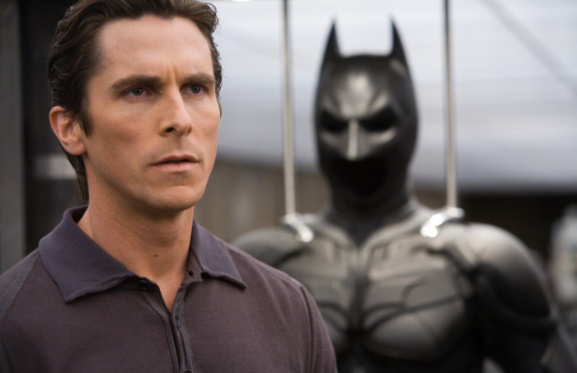

In [2]:
Image.open('experiment/bale.jpeg')

In [3]:
# setting up the categories
# our model outputs numbers as categories, so we much have a mapping from the numbers to the emotions
cat = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection', \
          'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear','Happiness', \
          'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']
cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(cat):
    cat2ind[emotion] = idx
    ind2cat[idx] = emotion

vad = ['Valence', 'Arousal', 'Dominance']
ind2vad = {}
for idx, continuous in enumerate(vad):
    ind2vad[idx] = continuous

In [4]:
# we need to normalise the demo image using the statistics of the training data the model was trained on
context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]
body_mean = [0.43832874, 0.3964344, 0.3706214]
body_std = [0.24784276, 0.23621225, 0.2323653]
context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]

prepared yolo model
{'bbox_0': {'cont': [5.2962165, 5.1647353, 5.6803427], 'cat': ['Annoyance', 'Confidence', 'Disapproval', 'Disquietment', 'Doubt/Confusion', 'Happiness', 'Pleasure', 'Sadness']}, 'bbox_1': {'cont': [5.0034957, 5.216226, 6.0208263], 'cat': ['Confidence', 'Disapproval', 'Disquietment', 'Doubt/Confusion', 'Engagement', 'Fatigue', 'Sadness', 'Suffering']}}


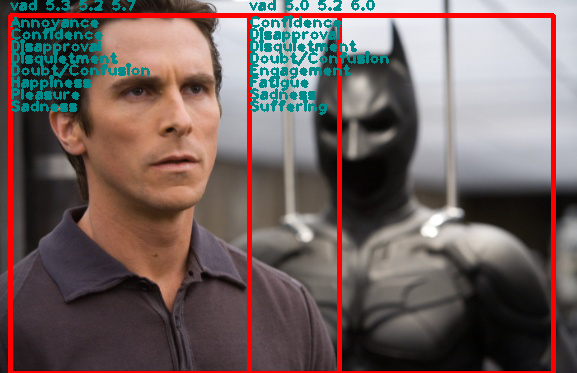

In [5]:
# pay attention to the arguments to the function,
# it takes a path to the image location, a result and model directory
# the result directory also contains threshold information to make decisions(please do not delete)
# write_op will write the output to a new file and return the location(2nd return variable)
# return_op will return the processed image as the 3rd return variable

xs, _, r = yolo_infer2('experiment/bale.jpeg', 'experiment/results/',
            'experiment/models/', context_norm, body_norm, ind2cat, ind2vad, write_op=False, return_op=True)

# the inference function returns a dict, top-level key is the bounding box. Each bounding box has sub keys:
#                1. cont - for continuous V-A-D emotion values
#                2. cat - for the top k categorical emotions
print(xs)
r

Looks like batman isn't impressed, neither is his suit, thanks YOLO. Yes this example was deliberately chosen to show a minor pitfall wherein YOLO_v3 recognises objects that may seem like faces. As a developer it is up to you how you choose to resolve this.

In [6]:
# in this example we are returning and writing the output image
xs, saved_op_loc, r = yolo_infer2('experiment/marvel_blackwidow_yelena1.jpg', 'experiment/results/',
            'experiment/models/', context_norm, body_norm, ind2cat, ind2vad, write_op=True, return_op=True)
xs

prepared yolo model


{'bbox_0': {'cont': [5.2071333, 5.4678273, 6.986942],
  'cat': ['Annoyance',
   'Confidence',
   'Disquietment',
   'Doubt/Confusion',
   'Engagement',
   'Yearning']}}

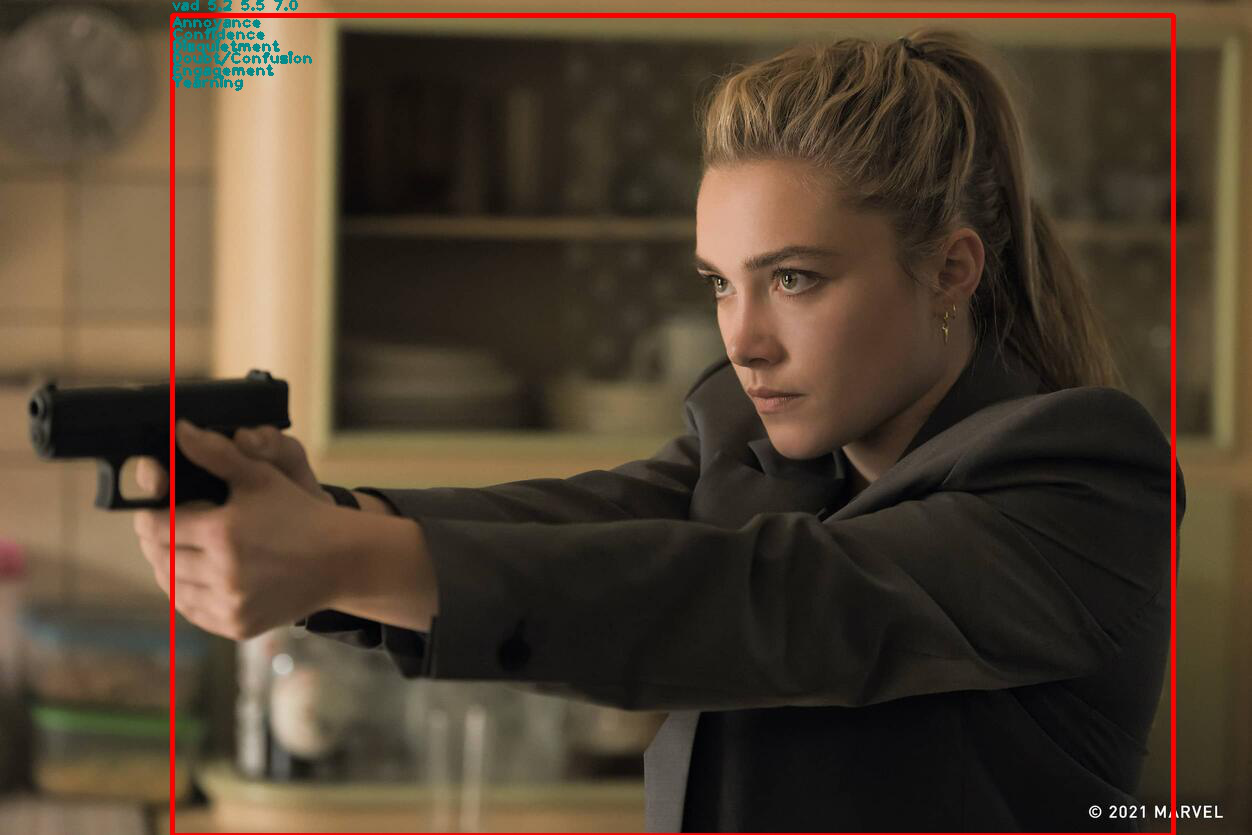

In [7]:
Image.open(saved_op_loc)

As evidenced above the function can give you a dictionary of V-A-D values for each detected face. Please feel free to incorporate this code in your project however you see fit. Below you'll find some pointers on how this could be integrated with Furhat.

# Integration with Furhat

As a part of the course project you are expected to make your own conversational bot, it should also make use of the emotional state of the user and respond accordingly. Below you'll find a few pointers for the same:

## Furhat Camera Feed
- One can refer to [Camera feed](https://docs.furhat.io/users/#camera-feed) docs, however you might encounter a few issues in getting it to work correctly (based on last year's experience)
- If this doesn't work (highly likely), you are encouraged to make an inference server and grant it access to your camera

## Alternatively
- If you want to use more advanced models feel free to do so, you may even reuse the pretrained models provided with this notebook
- You can use the inference function above and wrap it up with Flask (or other lib of your choice) and have it serve the inference API
- You may need to make minor changes based on your design idea, we have listed a few pointers you may wish to address
    - Perhaps the API needs to be equipped with extra code to capture an image?
    - Are you letting Furhat access the camera? Then maybe you need to split the camera stream
    

# What we want from you


- You are free to use code that is given with this lab. Emotion/affect recognition using the face is the bare minimum we expect to see in your implementation with Furhat - be creative with where you'd use this in the SpaceReceptionist (or a skill of your choosing)
- What we have given you is a implementation that can be worked by most people, we encourage you to try and implement multimodal models that could potentially be more accurate
- A successful incorporation with Furhat would require you to manage Furhat's behaviour with regards to the emotion detected
- Ultimately there should be 
    1. a short demo ~30s-1min showing your bot reacting to changes in emotion
    2. Prepare ground-truth labels and calculate the average accuracy of your system’s affect detection